In [7]:
from __future__ import print_function, division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

import pandas as pd

# Import data & initial guess

In [8]:
def create_filepaths(numbers, pre_path):
    padded_numbers = []
    file_ext = '.dat'
    for n in numbers:
        if n <= 9:
            padded_numbers = np.append(padded_numbers, pre_path + '00' + str(n) + file_ext)
        elif n <= 99:
            padded_numbers = np.append(padded_numbers, pre_path + '0' + str(n) + file_ext)
        else:
            padded_numbers = np.append(padded_numbers, pre_path + str(n) + file_ext)
    return padded_numbers

In [9]:
def decayingSinModel(time, freq, T_decay, amp, phase, offset, drift):
    # Linearly decaying sinusoidal function
    return amp * np.exp(-time/T_decay) * np.sin(2*np.pi*( freq*time ) + np.radians(phase)) + offset + (drift*time)

In [42]:
def ramsey_fit_guess_default():
    freq_guess = 5.5 # MHz
    T_decay_guess = 4.0 # us
    amp_guess = 0.2
    phase_guess = 120
    offset_guess = -0.7
    drift_guess = 0.0
    return [freq_guess, T_decay_guess, amp_guess, phase_guess, offset_guess, drift_guess]

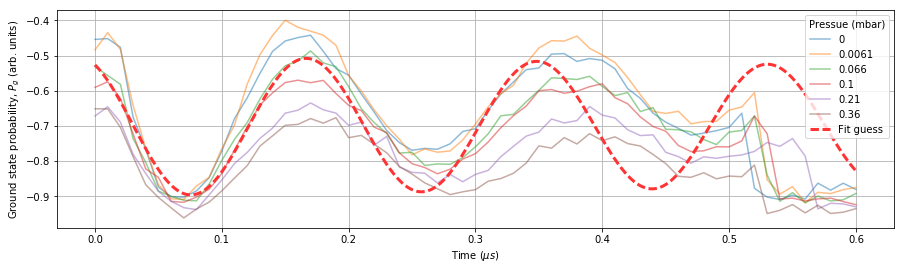

In [43]:
#date = '310317'
#file_numbers = [55,60,59,58,57,56]
#pressures = [0, 6.1E-3, 6.6E-2, 1.0E-1, 2.1E-1, 3.6E-1]
def ramsey_fit_test(date, file_numbers, pressures=[], guess=ramsey_fit_guess_default(), crop=[0,0]):
    file_path = "C:\data\\" + date + "\\SR" + date + "_"
    full_paths = create_filepaths(file_numbers, file_path)
    if pressures == []: pressures = np.arange(1, len(full_paths)+1, 1)

    matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)
    min_time, max_time = 0, 0
    for i, path in enumerate(full_paths):
        data = np.loadtxt(path)
        time = data[:,1] * 1E6
        time = time[crop[0]:len(time)-crop[1]]
        p_g = data[:,4] * 1E9
        p_g = p_g[crop[0]:len(p_g)-crop[1]]
        
        min_time = np.min([min_time, np.min(time)])
        max_time = np.max([max_time, np.max(time)])
        
        plt.plot(time, p_g, alpha=0.5, label=str(pressures[i]))

    timeSteps = np.linspace(min_time, max_time, 1000)

    plt.plot(timeSteps, decayingSinModel(timeSteps, *guess), '--', lw=3, color=[1.0,0.2,0.2], label='Fit guess')
    plt.xlabel('Time ($\mu s$)')
    plt.ylabel('Ground state probability, $P_g$ (arb. units)')
    plt.grid()
    plt.legend(title='Pressue (mbar)')

#ramsey_fit_test(date, file_numbers, pressures)

# Fit sinusoidal waveforms

,Pressure,Frequency,Frequency error,T decay,T decay error,Amplitude,Amplitude error,Initial phase,Initial phase error,Offset,Offset error,Drift,Drift error,Phase shift /t
0,0.0000,5.040389,0.068286,-6.919154e+06,1.177163e+13,0.167190,0.020812,138.894692,7.245039,-0.659077,0.015828,0.133567,0.052997,0.000000
1,0.0061,5.040751,0.065419,-8.389517e+06,1.324847e+13,0.184099,0.017594,139.752727,6.986182,-0.648515,0.018274,0.171718,0.062876,0.130532
2,0.0660,4.953467,0.067713,-2.324237e+07,3.361100e+13,0.146001,0.010671,140.178937,7.000417,-0.712351,0.013245,0.158954,0.044228,-31.291646
3,0.1000,4.971548,0.059346,-1.863579e+07,2.820348e+13,0.134069,0.008046,137.007110,6.174948,-0.732412,0.010805,0.139090,0.036460,-24.782529
4,0.2100,4.921201,0.068522,-1.917526e+07,2.730134e+13,0.105212,0.007454,132.854803,6.998874,-0.784353,0.009807,0.118784,0.033718,-42.907457
5,0.3600,4.812217,0.080477,-1.164274e+07,1.567738e+13,0.098806,0.007832,134.134339,8.065532,-0.795899,0.010394,0.011785,0.035100,-82.141721


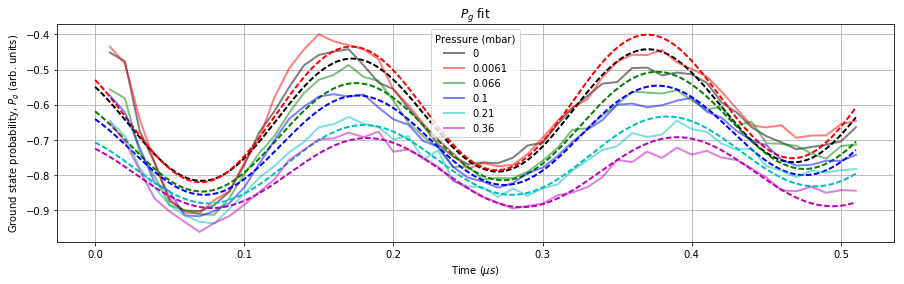

In [44]:
def ramsey_fit(date, file_numbers, pressures=[], guess=ramsey_fit_guess_default(), eval_time=0.0, crop=[0,0]):
    file_path = "C:\data\\" + date + "\\SR" + date + "_"
    full_paths = create_filepaths(file_numbers, file_path)
    
    matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)
    colors = ['k','r','g','b','c','m','y']
    params = ['Frequency', 'T decay', 'Amplitude', 'Initial phase', 'Offset', 'Drift']
    if pressures == []: pressures = np.arange(1, len(full_paths)+1, 1)
        
    popts = []
    perrs = []
    df = pd.DataFrame(columns=['Pressure', *params, *[p + ' error' for p in params]])
    min_time, max_time = 0, 0
    for i, path in enumerate(full_paths):
        data = np.loadtxt(path)
        time = data[:,1] * 1E6
        time = time[crop[0]:len(time)-crop[1]]
        p_g = data[:,4] * 1E9
        p_g = p_g[crop[0]:len(p_g)-crop[1]]
        
        min_time = np.min([min_time, np.min(time)])
        max_time = np.max([max_time, np.max(time)])

        popt,pcov = curve_fit(decayingSinModel, time, p_g, p0=guess)
        perr = np.sqrt(np.diag(pcov))
        popts = np.concatenate((popts, popt), axis=0)
        perrs = np.concatenate((perrs, perr), axis=0)

        df.loc[i] = [pressures[i], *popt, *perr]
        matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)

        timeSteps = np.linspace(min_time, max_time, 1000)
        p_g_fit = decayingSinModel(timeSteps, *popt)
        plt.plot(time, p_g, '-', lw=2, color=colors[np.mod(i, len(colors))], alpha=0.5, label=str(pressures[i]))
        plt.plot(timeSteps, p_g_fit, '--', lw=2, color=colors[np.mod(i, len(colors))], alpha=1.0)

    plt.xlabel('Time ($\mu s$)')
    plt.ylabel('Ground state probability, $P_g$ (arb. units)')
    plt.title('$P_g$ fit')
    plt.grid()
    plt.legend(title='Pressure (mbar)')

    popts = np.reshape(popts, [len(file_numbers), len(params)])
    perrs = np.reshape(perrs, [len(file_numbers), len(params)])
    ref_popt = popts[0]
    diff_freq = popts[:,0] - ref_popt[0]
    diff_init_phase = popts[:,3] - ref_popt[3]
    if eval_time != 0.0: diff_eval_phase = (360 * diff_freq * eval_time) + diff_init_phase # MHz * us
    diff_phase = (360 * diff_freq)

    if eval_time != 0.0: plt.axvline(x=eval_time, color='r', linestyle='--')

    df['Phase shift /t'] = diff_phase
    if eval_time != 0.0: df['Phase shift at T'] = diff_eval_phase
    columns = ['Pressure', *list(np.array([[p, p + ' error'] for p in params]).flatten()), 'Phase shift /t']
    if eval_time != 0.0: columns = [*columns, 'Phase shift at T']
    return df[columns]
    
#df = ramsey_fit(date, file_numbers, pressures, crop=[1,9])
#df

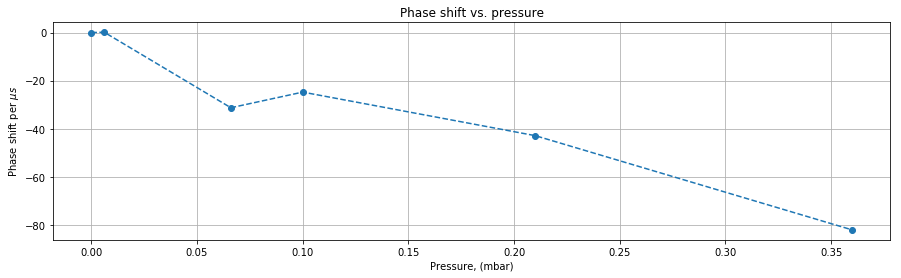

In [45]:
def ramsey_plot_pressure_phase(df):
    plt.plot(df['Pressure'], df['Phase shift /t'], 'o--')
    plt.title('Phase shift vs. pressure')
    plt.xlabel('Pressure, (mbar)')
    plt.ylabel('Phase shift per $\mu s$')
    plt.grid()
#ramsey_plot_pressure_phase(df)